# Stroke prediction


#### Data source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

## Importing libraries

In [87]:
# Inline plotting
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os


## Reading dataset dataset

In [88]:
df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')
print (df.head(5))

      id  gender   age  hypertension  heart_disease ever_married   
0   9046    Male  67.0             0              1          Yes  \
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status   
0        Private          Urban             228.69  36.6  formerly smoked  \
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  


## Dataset information

In [89]:
print("Dataset info:")
print( "Data shape: ", df.shape)
print(df.head())
print("="*80)
print(df.isnull().sum())

Dataset info:
Data shape:  (5110, 12)
      id  gender   age  hypertension  heart_disease ever_married   
0   9046    Male  67.0             0              1          Yes  \
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status   
0        Private          Urban             228.69  36.6  formerly smoked  \
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
id                

## Data preprocessing

### Data analysis

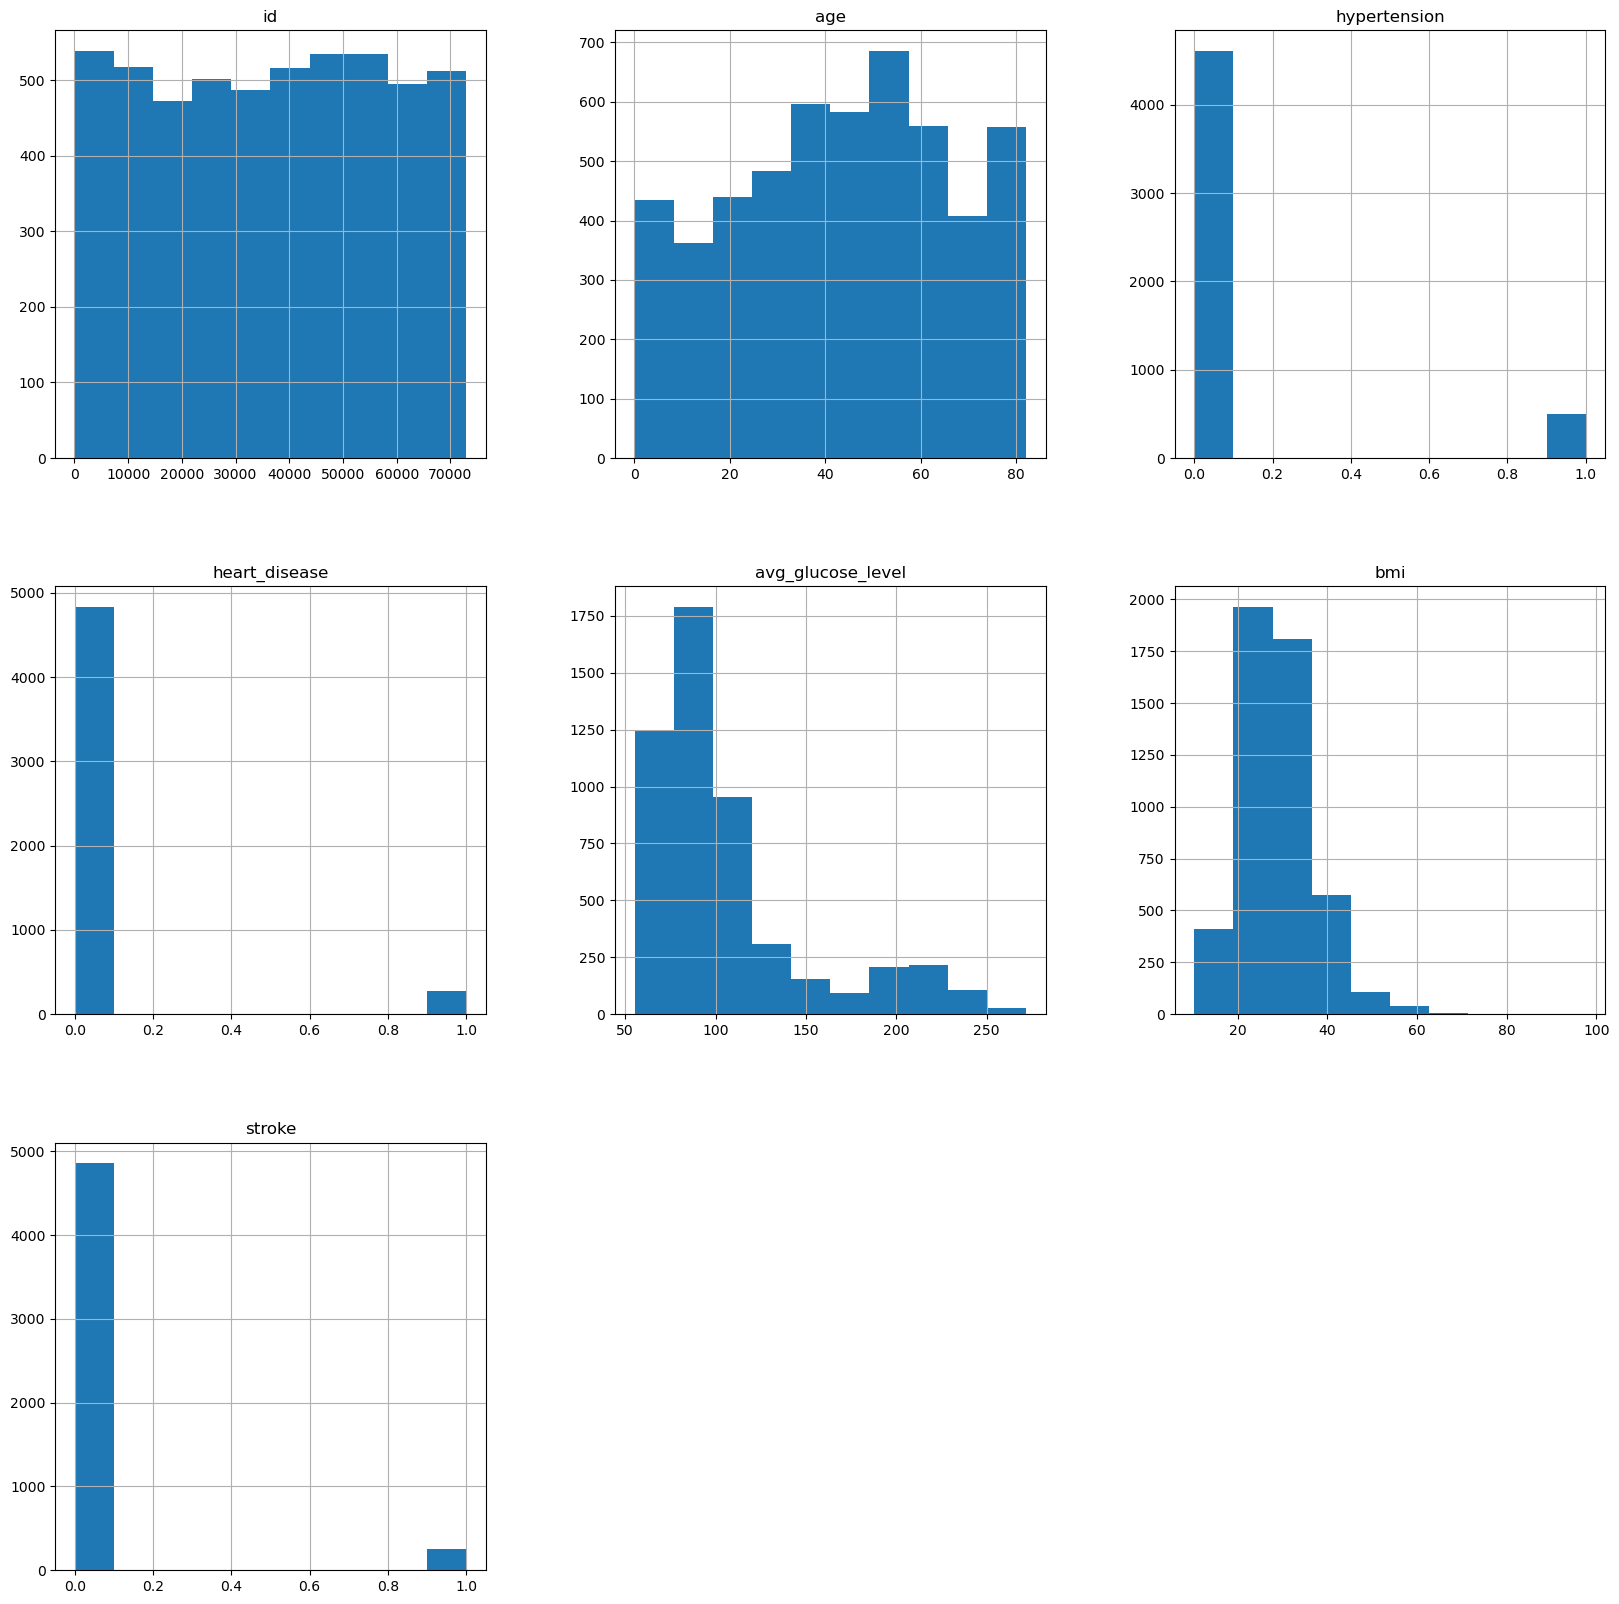

In [90]:
# Visualize the distribution of each feature
df.hist(figsize=(20, 20))
plt.show()


Label Encoder Transformation
gender  :  [1 0 2]  =  ['Male' 'Female' 'Other']
ever_married  :  [1 0]  =  ['Yes' 'No']
work_type  :  [2 3 0 4 1]  =  ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type  :  [1 0]  =  ['Urban' 'Rural']
smoking_status  :  [1 2 3 0]  =  ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
Label Encoder Transformation Completed


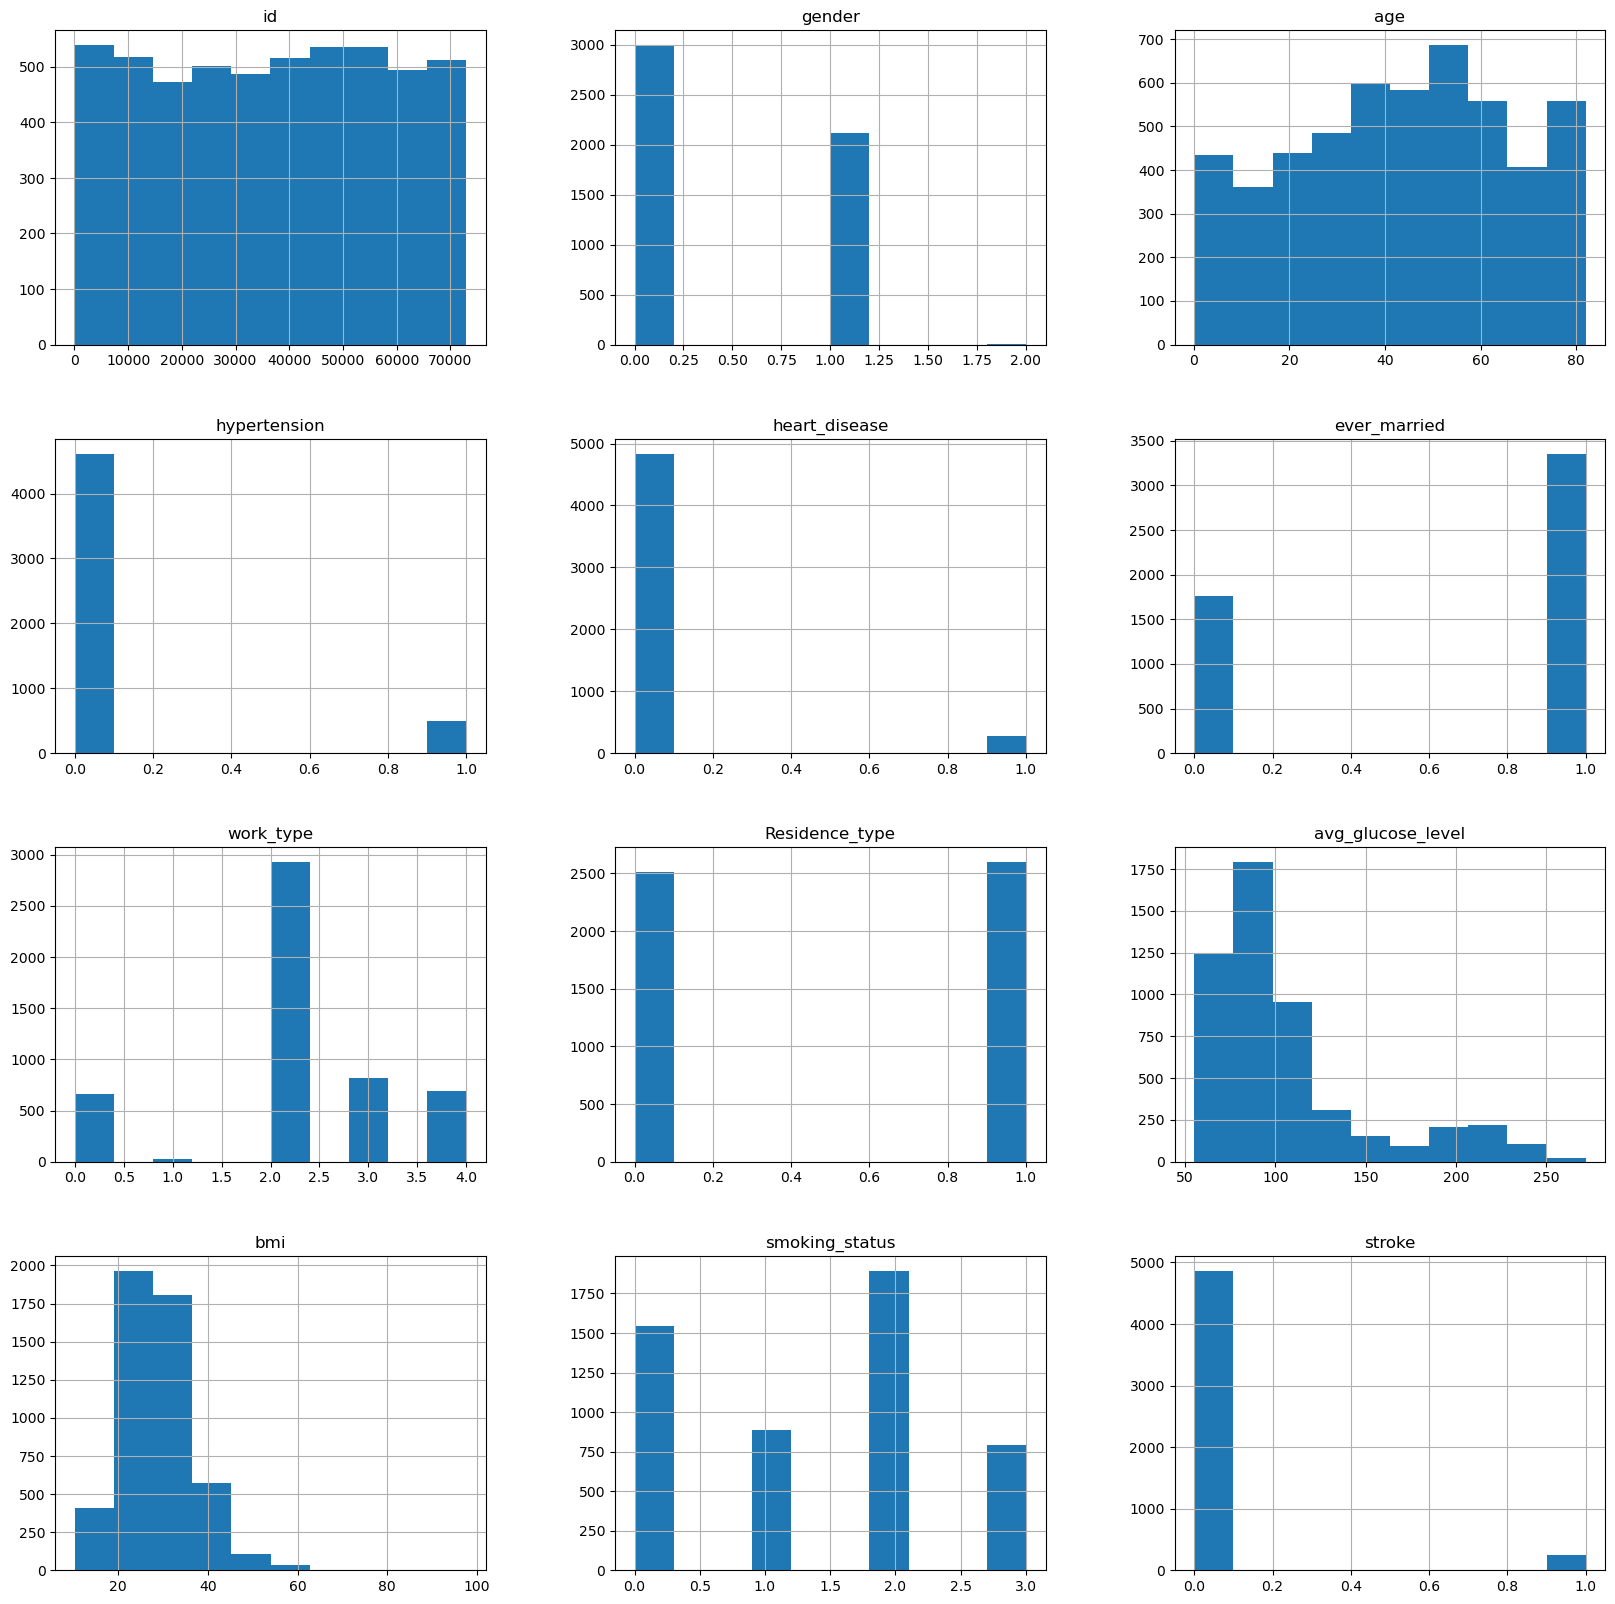

In [91]:
# Encode categorical features

le = LabelEncoder()
text_data_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
l3 = []; l4 = [];
print('Label Encoder Transformation')
for i in text_data_features:
    df[i] = le.fit_transform(df[i])
    l3.append(list(df[i].unique())); l4.append(list(le.inverse_transform(df[i].unique())))
    print(i,' : ',df[i].unique(),' = ',le.inverse_transform(df[i].unique()))
print('Label Encoder Transformation Completed')

# Visualize the distribution of each feature
df.hist(figsize=(20, 20))
plt.show()


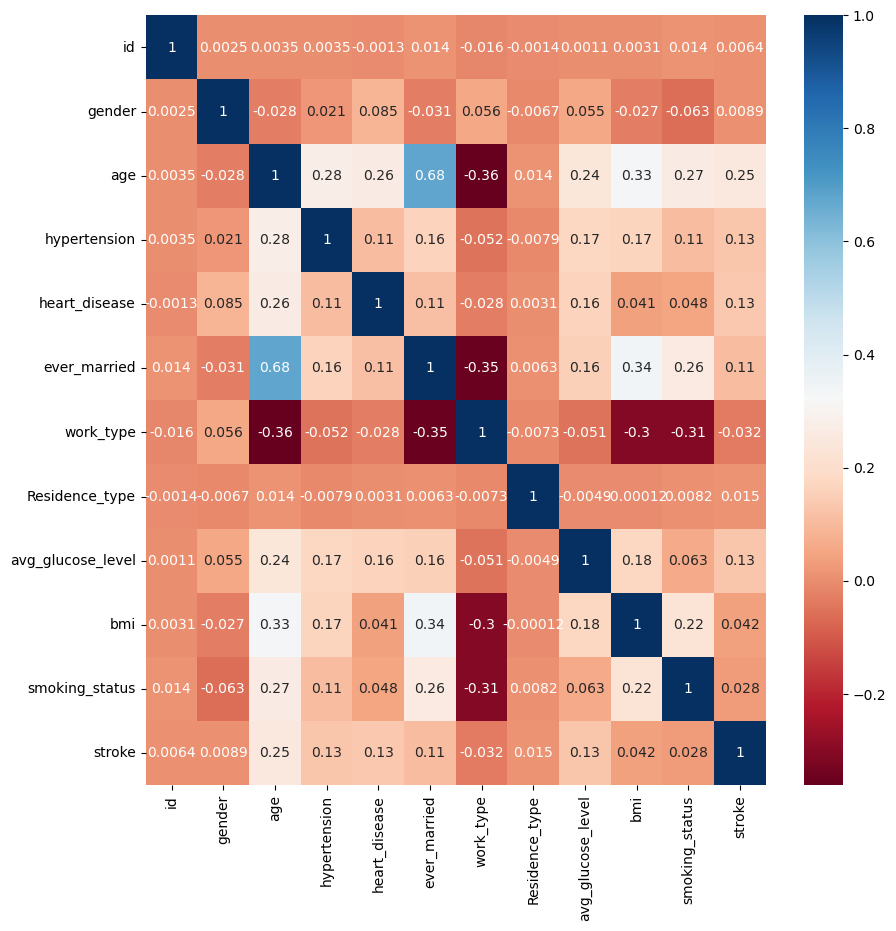

In [92]:
# Visualize the correlation between features
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cmap="RdBu")
plt.show()


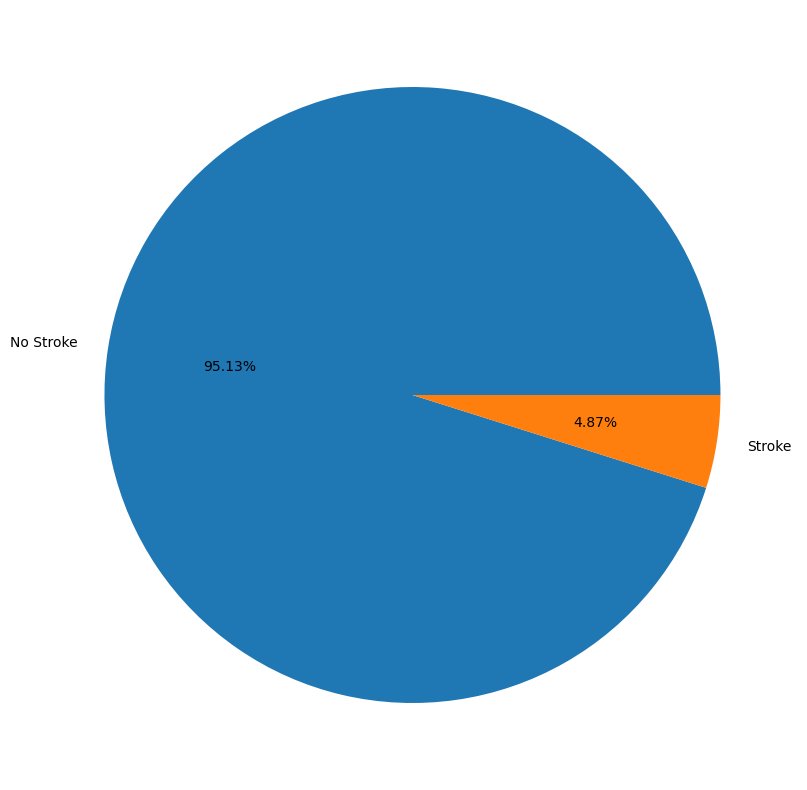

In [93]:
# Visualize the distribution of stroke in percentage

plt.figure(figsize=(10, 10))
plt.pie(df['stroke'].value_counts(), labels=['No Stroke', 'Stroke'], autopct='%1.2f%%')
plt.show()


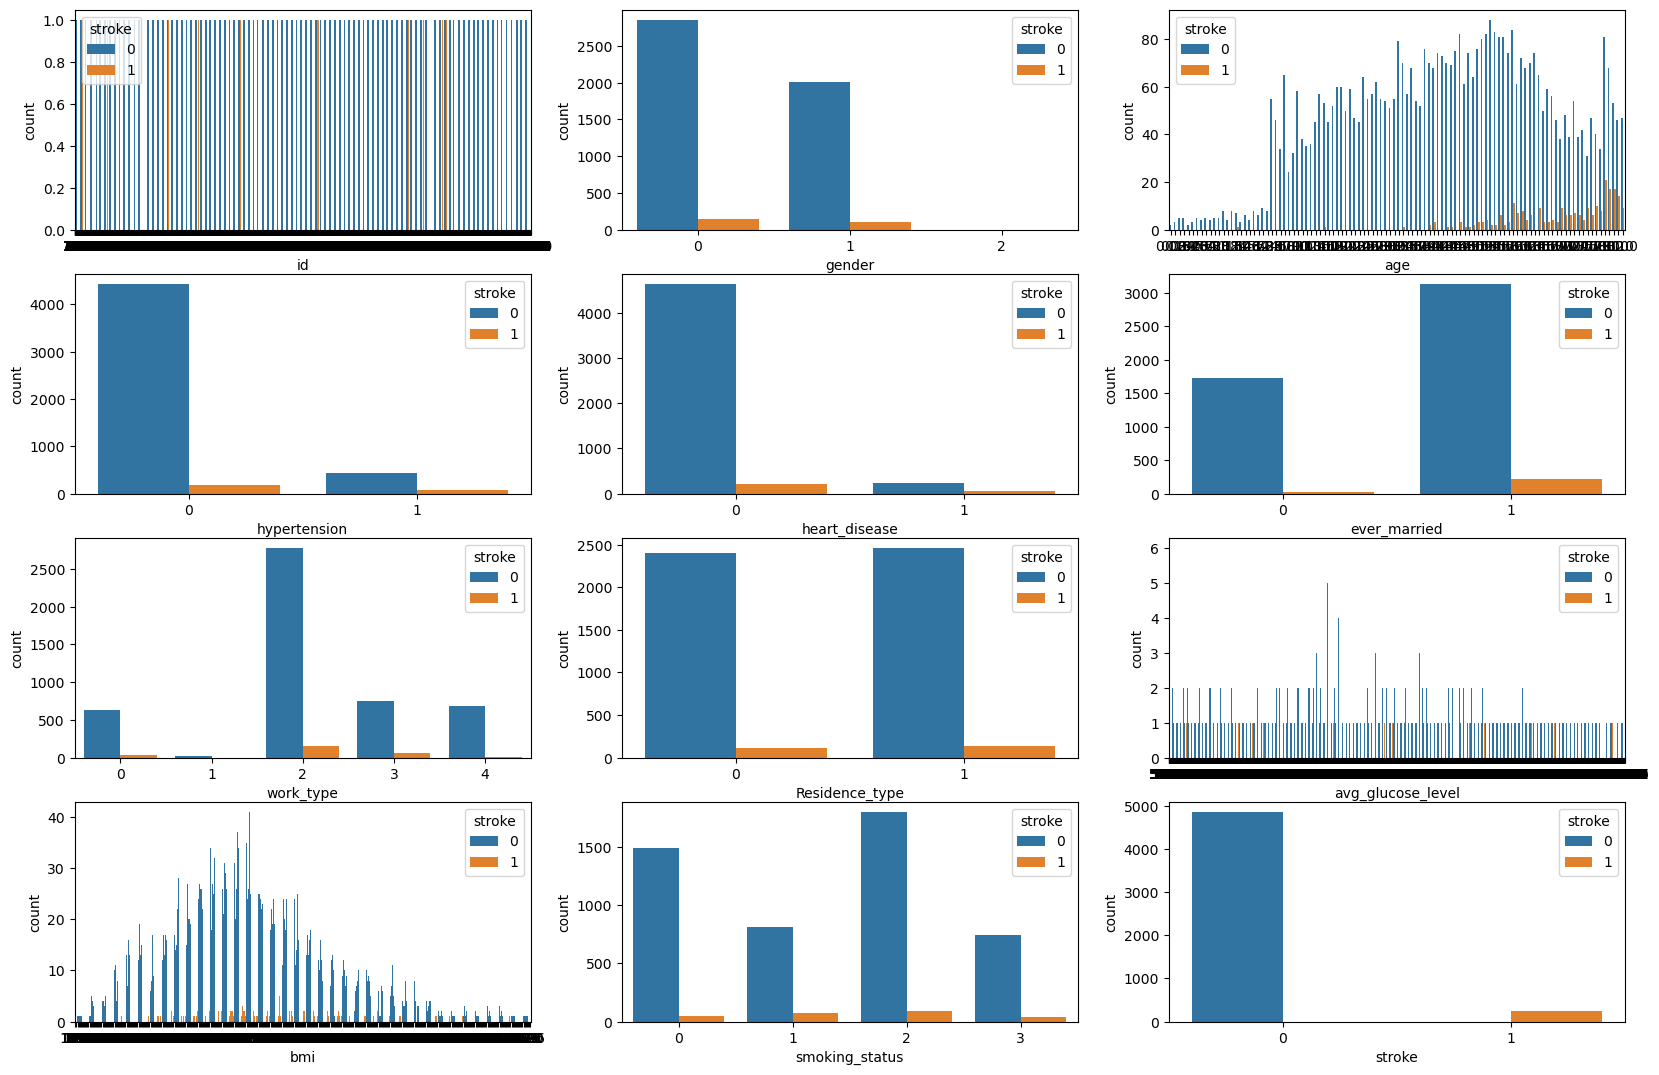

In [94]:
# correlation between stroke and other features
plt.figure(figsize=(20, 20))
for i, col in enumerate(df.columns):
    plt.subplot(6, 3, i+1)
    sns.countplot(x=col, hue='stroke', data=df)
plt.show()


#### Observations
The stroke appears to have correlation between the following variables:
* Age
* hypertension
* heart_disease
* glucose_level

In [95]:
# Treat missing values, # Replace missing values with mean
df['bmi'].fillna(df['bmi'].mean(), inplace=True)

In [96]:
# Remove outliers
df = df[df['bmi'] < 50]

In [97]:
# Split the data into train and test maintaining the same distribution of the target variable
from sklearn.model_selection import train_test_split
X = df.drop('stroke', axis=1)
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1313, stratify=y)


In [98]:
# Oversampling the minority class
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train_res, y_train_res = oversample.fit_resample(X_train, y_train.ravel())


# Model evaluation

## Neural Network

Best Validation Loss: 0.6624
Best Validation Accuracy: 0.9510
48/48 [==============================] - 0s 745us/step
[[1313  123]
 [  55   19]]


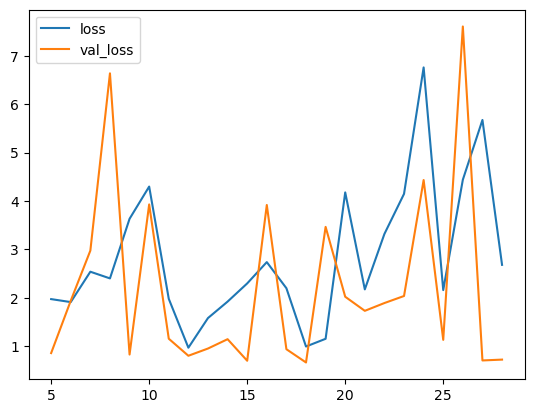

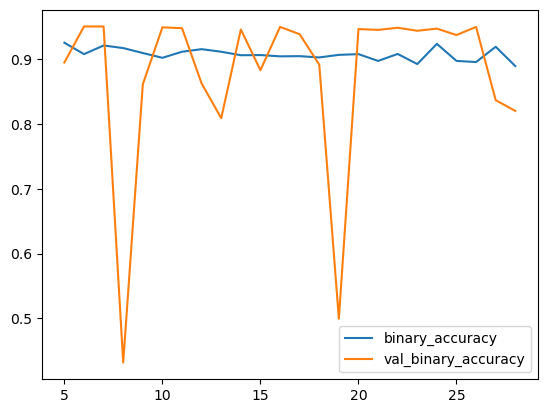

In [111]:

# Tensorflow imports for simple neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Train a simple neural network to compare with the other models

# Create a simple neural network for binary classification
model = Sequential()
model.add(Dense(16, input_dim=X_train_res.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)


early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=128,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

# Confusion matrix of the trained model
y_perd = model.predict(X_test)
y_pred = np.where(y_perd > 0.5, 1, 0)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)


#### Observations of neural network

Due to the small amount of data, the neural network is not able to generalize the data, so the accuracy is high, but recall is low, which means that the model is not able to predict the stroke. Clasical machine learning algorithms are more suitable for this problem.

## Random Forest

In [14]:
# Train and optimize models with mlflow and hyperopt to get the best recall score
import mlflow
import mlflow.sklearn
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier

mlflow.set_experiment("stroke")

# Define the search space for random forest model
space = {'max_depth': hp.choice('max_depth', range(1, 20)),
            'n_estimators': hp.choice('n_estimators', range(1, 250)),
            'criterion': hp.choice('criterion', ['gini', 'entropy']),
            'max_features': hp.choice('max_features', ['sqrt', 'log2'])
}

# Define the objective function
def objective(space):
    with mlflow.start_run():

        model = RandomForestClassifier(max_depth=space['max_depth'],
                                        n_estimators=space['n_estimators'],
                                        criterion=space['criterion'],
                                        max_features=space['max_features'],
                                        # Use all available cores to speed up training
                                        n_jobs=-1)
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test)
        recall = recall_score(y_test, y_pred)
        mlflow.log_param("max_depth", space['max_depth'])
        mlflow.log_param("n_estimators", space['n_estimators'])
        mlflow.log_param("criterion", space['criterion'])
        mlflow.log_param("max_features", space['max_features'])
        mlflow.log_metric("recall", recall)
        mlflow.sklearn.log_model(model, "model")
        return {'loss': -recall, 'status': STATUS_OK}    

# Run the optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=500,
            trials=trials)

# Print the best parameters
print(best)

# Print the best recall score
print(-trials.best_trial['result']['loss'])

# Parameters of the best model
print(trials.best_trial['misc']['vals'])


# Hyper parameter dictionary
hyper_params = {'max_depth': range(1, 20),
                'n_estimators': range(1, 250),
                'criterion': ['gini', 'entropy'],
                'max_features':['sqrt', 'log2']}

# Train the model with the best parameters
model = RandomForestClassifier(max_depth=best['max_depth'],
                                n_estimators=best['n_estimators'],
                                criterion=best['criterion'],
                                max_features=best['max_features'],
                                # Use all available cores to speed up training
                                n_jobs=-1)

model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test)
recall = recall_score(y_test, y_pred)
print('Recall score: ', recall)
y_pred = model.predict(X_test)
recall = recall_score(y_test, y_pred)
print(recall)
mlflow.sklearn.log_model(model, "model")
# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

import pickle
filename = './models/RFC/finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')

# end run
mlflow.end_run()


  0%|          | 1/500 [00:03<27:09,  3.27s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



100%|██████████| 500/500 [22:45<00:00,  2.73s/trial, best loss: -0.9054054054054054]
{'criterion': 1, 'max_depth': 0, 'max_features': 0, 'n_estimators': 183}
0.9054054054054054
{'criterion': [1], 'max_depth': [0], 'max_features': [0], 'n_estimators': [183]}


Text(0.5, 1.0, 'Confusion matrix')

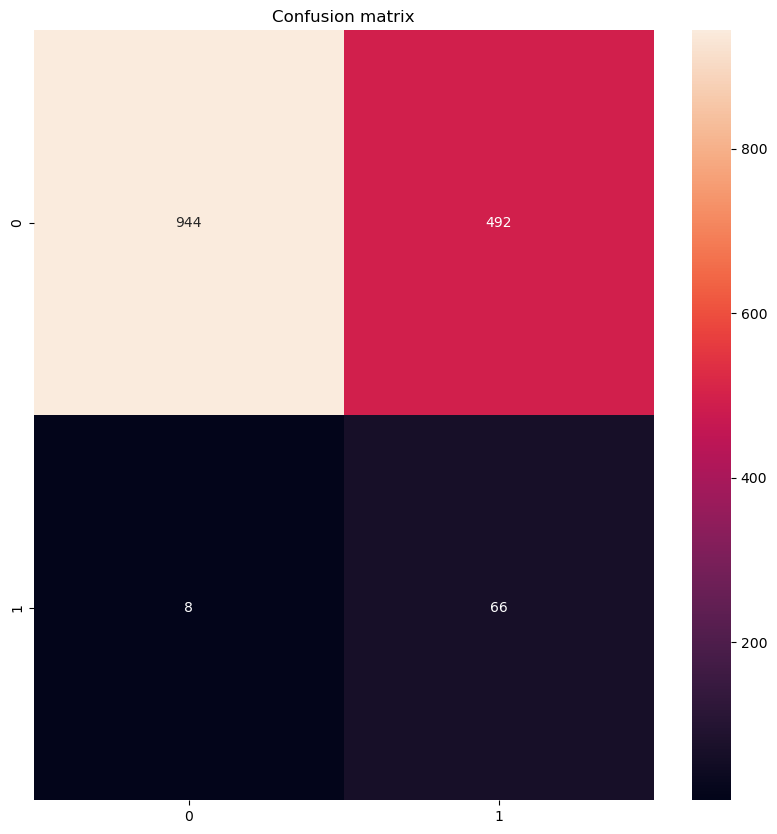

## Logistic Regression

  0%|          | 0/500 [00:00<?, ?trial/s, best loss=?]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  0%|          | 1/500 [00:02<24:13,  2.91s/trial, best loss: -0.8108108108108109]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



  0%|          | 2/500 [00:05<23:54,  2.88s/trial, best loss: -0.8108108108108109]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  1%|          | 4/500 [00:11<24:55,  3.02s/trial, best loss: -0.8108108108108109]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



  1%|          | 5/500 [00:15<25:33,  3.10s/trial, best loss: -0.8108108108108109]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  1%|          | 6/500 [00:17<24:54,  3.03s/trial, best loss: -0.8108108108108109]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  1%|▏         | 7/500 [00:20<23:56,  2.91s/trial, best loss: -0.8108108108108109]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



  2%|▏         | 8/500 [00:23<23:43,  2.89s/trial, best loss: -0.8108108108108109]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  2%|▏         | 10/500 [00:29<23:16,  2.85s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



  2%|▏         | 11/500 [00:31<23:15,  2.85s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



  3%|▎         | 13/500 [00:37<23:32,  2.90s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  3%|▎         | 14/500 [00:40<22:41,  2.80s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  3%|▎         | 15/500 [00:43<22:43,  2.81s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  3%|▎         | 16/500 [00:45<21:48,  2.70s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  3%|▎         | 17/500 [00:48<21:36,  2.69s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  4%|▎         | 18/500 [00:51<22:19,  2.78s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  4%|▍         | 19/500 [00:53<21:47,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  4%|▍         | 20/500 [00:56<21:57,  2.74s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  4%|▍         | 21/500 [00:59<21:43,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  4%|▍         | 22/500 [01:01<21:10,  2.66s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  5%|▍         | 24/500 [01:07<21:10,  2.67s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  5%|▌         | 25/500 [01:10<21:32,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  5%|▌         | 26/500 [01:12<21:31,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  6%|▌         | 28/500 [01:18<21:40,  2.76s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  6%|▌         | 29/500 [01:21<21:53,  2.79s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  6%|▋         | 32/500 [01:29<21:02,  2.70s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  7%|▋         | 33/500 [01:31<21:20,  2.74s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  7%|▋         | 34/500 [01:34<21:34,  2.78s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  7%|▋         | 35/500 [01:37<21:28,  2.77s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  7%|▋         | 36/500 [01:40<20:54,  2.70s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  8%|▊         | 39/500 [01:48<21:34,  2.81s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  8%|▊         | 41/500 [01:54<21:44,  2.84s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  8%|▊         | 42/500 [01:56<20:55,  2.74s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  9%|▊         | 43/500 [01:59<20:59,  2.76s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



  9%|▉         | 45/500 [02:04<19:48,  2.61s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  9%|▉         | 46/500 [02:07<19:37,  2.59s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



  9%|▉         | 47/500 [02:09<19:26,  2.58s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 10%|▉         | 49/500 [02:14<19:19,  2.57s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 10%|█         | 50/500 [02:17<19:22,  2.58s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 10%|█         | 51/500 [02:20<19:09,  2.56s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 11%|█         | 54/500 [02:28<19:18,  2.60s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 11%|█         | 55/500 [02:30<19:27,  2.62s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 11%|█▏        | 57/500 [02:35<19:08,  2.59s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 12%|█▏        | 60/500 [02:43<19:00,  2.59s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 12%|█▏        | 61/500 [02:46<19:58,  2.73s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 12%|█▏        | 62/500 [02:49<19:52,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 13%|█▎        | 64/500 [02:54<18:39,  2.57s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 13%|█▎        | 65/500 [02:57<18:46,  2.59s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 13%|█▎        | 66/500 [02:59<18:35,  2.57s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 13%|█▎        | 67/500 [03:02<18:30,  2.56s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 14%|█▎        | 68/500 [03:04<18:34,  2.58s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 14%|█▍        | 69/500 [03:07<19:02,  2.65s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 14%|█▍        | 70/500 [03:10<19:31,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 14%|█▍        | 71/500 [03:13<18:59,  2.66s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 14%|█▍        | 72/500 [03:16<19:52,  2.79s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 15%|█▍        | 73/500 [03:19<20:25,  2.87s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 15%|█▍        | 74/500 [03:22<20:30,  2.89s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 15%|█▌        | 75/500 [03:25<20:26,  2.88s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 16%|█▌        | 78/500 [03:33<19:15,  2.74s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 16%|█▌        | 79/500 [03:35<19:09,  2.73s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 16%|█▌        | 80/500 [03:38<18:26,  2.64s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 16%|█▌        | 81/500 [03:41<18:54,  2.71s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 17%|█▋        | 83/500 [03:46<18:20,  2.64s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 17%|█▋        | 84/500 [03:49<19:06,  2.76s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 17%|█▋        | 85/500 [03:52<20:06,  2.91s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 17%|█▋        | 86/500 [03:55<20:53,  3.03s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 17%|█▋        | 87/500 [03:59<21:38,  3.14s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 18%|█▊        | 89/500 [04:04<20:32,  3.00s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 18%|█▊        | 90/500 [04:07<20:29,  3.00s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 18%|█▊        | 91/500 [04:10<20:24,  2.99s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 18%|█▊        | 92/500 [04:14<21:05,  3.10s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 19%|█▊        | 93/500 [04:16<19:52,  2.93s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 19%|█▉        | 94/500 [04:19<19:31,  2.88s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 19%|█▉        | 95/500 [04:22<19:23,  2.87s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 19%|█▉        | 97/500 [04:28<19:26,  2.89s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 20%|█▉        | 98/500 [04:31<19:17,  2.88s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 20%|██        | 101/500 [04:38<17:40,  2.66s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 21%|██        | 103/500 [04:44<17:29,  2.64s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 21%|██        | 104/500 [04:47<18:36,  2.82s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 21%|██        | 105/500 [04:50<19:03,  2.90s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 21%|██        | 106/500 [04:53<18:34,  2.83s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 21%|██▏       | 107/500 [04:55<17:50,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 22%|██▏       | 108/500 [04:58<18:05,  2.77s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 22%|██▏       | 110/500 [05:03<17:13,  2.65s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 22%|██▏       | 111/500 [05:06<17:07,  2.64s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 22%|██▏       | 112/500 [05:09<18:24,  2.85s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 23%|██▎       | 113/500 [05:12<19:19,  3.00s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 23%|██▎       | 114/500 [05:16<19:33,  3.04s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 23%|██▎       | 115/500 [05:19<19:56,  3.11s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 23%|██▎       | 116/500 [05:22<20:15,  3.16s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 23%|██▎       | 117/500 [05:25<20:05,  3.15s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 24%|██▎       | 118/500 [05:28<19:11,  3.01s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 24%|██▍       | 119/500 [05:31<18:57,  2.99s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 24%|██▍       | 120/500 [05:34<18:54,  2.99s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 24%|██▍       | 121/500 [05:37<19:27,  3.08s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 24%|██▍       | 122/500 [05:40<19:56,  3.16s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 25%|██▍       | 123/500 [05:43<19:15,  3.06s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 25%|██▍       | 124/500 [05:46<18:23,  2.93s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 25%|██▌       | 125/500 [05:49<18:36,  2.98s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 25%|██▌       | 126/500 [05:51<17:33,  2.82s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 25%|██▌       | 127/500 [05:54<16:40,  2.68s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 26%|██▌       | 128/500 [05:56<16:26,  2.65s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 26%|██▌       | 129/500 [05:59<16:38,  2.69s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 26%|██▌       | 130/500 [06:02<16:39,  2.70s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 26%|██▌       | 131/500 [06:05<17:02,  2.77s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 26%|██▋       | 132/500 [06:07<16:12,  2.64s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 27%|██▋       | 133/500 [06:10<15:57,  2.61s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 27%|██▋       | 134/500 [06:12<15:44,  2.58s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 27%|██▋       | 135/500 [06:15<15:53,  2.61s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 27%|██▋       | 136/500 [06:17<15:22,  2.53s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 27%|██▋       | 137/500 [06:20<15:31,  2.57s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 28%|██▊       | 138/500 [06:23<15:42,  2.60s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 28%|██▊       | 139/500 [06:26<16:12,  2.69s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 28%|██▊       | 140/500 [06:29<17:20,  2.89s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 28%|██▊       | 141/500 [06:32<17:30,  2.93s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 28%|██▊       | 142/500 [06:35<17:20,  2.91s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 29%|██▊       | 143/500 [06:37<16:54,  2.84s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 29%|██▉       | 145/500 [06:43<16:01,  2.71s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 29%|██▉       | 146/500 [06:45<16:04,  2.73s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 29%|██▉       | 147/500 [06:48<16:03,  2.73s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 30%|██▉       | 149/500 [06:54<15:51,  2.71s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 30%|███       | 150/500 [06:57<16:16,  2.79s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 30%|███       | 152/500 [07:02<15:24,  2.66s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 31%|███       | 153/500 [07:04<15:01,  2.60s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 31%|███       | 155/500 [07:10<15:13,  2.65s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 31%|███       | 156/500 [07:13<16:01,  2.79s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 31%|███▏      | 157/500 [07:16<16:17,  2.85s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 32%|███▏      | 158/500 [07:18<15:49,  2.78s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 32%|███▏      | 160/500 [07:23<14:54,  2.63s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 32%|███▏      | 161/500 [07:26<15:00,  2.66s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 32%|███▏      | 162/500 [07:29<14:46,  2.62s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 33%|███▎      | 163/500 [07:31<14:44,  2.62s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 33%|███▎      | 164/500 [07:34<14:50,  2.65s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 33%|███▎      | 165/500 [07:37<15:15,  2.73s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 33%|███▎      | 166/500 [07:40<15:46,  2.83s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 33%|███▎      | 167/500 [07:43<15:52,  2.86s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 34%|███▎      | 168/500 [07:46<15:38,  2.83s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 34%|███▍      | 169/500 [07:48<15:41,  2.84s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 34%|███▍      | 170/500 [07:51<15:17,  2.78s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 34%|███▍      | 172/500 [07:56<14:45,  2.70s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 35%|███▍      | 173/500 [07:59<15:04,  2.77s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 35%|███▍      | 174/500 [08:02<14:45,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 35%|███▌      | 175/500 [08:05<15:17,  2.82s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 35%|███▌      | 176/500 [08:08<14:57,  2.77s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 36%|███▌      | 178/500 [08:13<14:15,  2.66s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 36%|███▌      | 179/500 [08:16<14:50,  2.78s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 36%|███▌      | 180/500 [08:19<14:42,  2.76s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 36%|███▋      | 182/500 [08:24<14:25,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 37%|███▋      | 183/500 [08:27<14:24,  2.73s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 37%|███▋      | 184/500 [08:30<14:39,  2.78s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 37%|███▋      | 185/500 [08:33<14:45,  2.81s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 38%|███▊      | 188/500 [08:41<14:03,  2.70s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 38%|███▊      | 189/500 [08:43<14:07,  2.73s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 38%|███▊      | 191/500 [08:49<14:10,  2.75s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 39%|███▉      | 194/500 [08:57<13:21,  2.62s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 39%|███▉      | 195/500 [09:00<13:39,  2.69s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 39%|███▉      | 196/500 [09:03<14:11,  2.80s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 39%|███▉      | 197/500 [09:05<13:40,  2.71s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 40%|███▉      | 198/500 [09:08<13:43,  2.73s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 40%|███▉      | 199/500 [09:11<14:11,  2.83s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 40%|████      | 200/500 [09:14<14:10,  2.83s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 40%|████      | 201/500 [09:17<14:08,  2.84s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 40%|████      | 202/500 [09:19<13:44,  2.77s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 41%|████      | 203/500 [09:22<13:55,  2.81s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 41%|████      | 205/500 [09:27<13:09,  2.68s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 41%|████▏     | 207/500 [09:33<13:15,  2.71s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 42%|████▏     | 210/500 [09:41<12:51,  2.66s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 42%|████▏     | 211/500 [09:44<13:11,  2.74s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 42%|████▏     | 212/500 [09:47<13:28,  2.81s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 43%|████▎     | 213/500 [09:50<13:30,  2.82s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 43%|████▎     | 214/500 [09:52<13:40,  2.87s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 43%|████▎     | 215/500 [09:55<13:11,  2.78s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 43%|████▎     | 216/500 [09:58<12:56,  2.73s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 43%|████▎     | 217/500 [10:00<12:44,  2.70s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 44%|████▎     | 218/500 [10:03<12:47,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 44%|████▍     | 219/500 [10:06<12:38,  2.70s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 44%|████▍     | 221/500 [10:11<12:36,  2.71s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 44%|████▍     | 222/500 [10:14<12:50,  2.77s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 45%|████▍     | 223/500 [10:17<12:42,  2.75s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 45%|████▍     | 224/500 [10:20<12:33,  2.73s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 46%|████▌     | 228/500 [10:30<11:57,  2.64s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 46%|████▌     | 230/500 [10:36<12:20,  2.74s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 46%|████▋     | 232/500 [10:42<12:39,  2.84s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 47%|████▋     | 233/500 [10:45<12:36,  2.83s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 47%|████▋     | 234/500 [10:47<12:22,  2.79s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 47%|████▋     | 235/500 [10:50<12:26,  2.82s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 47%|████▋     | 236/500 [10:53<12:05,  2.75s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 47%|████▋     | 237/500 [10:55<11:42,  2.67s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 48%|████▊     | 238/500 [10:58<12:08,  2.78s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 48%|████▊     | 239/500 [11:01<12:25,  2.86s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 48%|████▊     | 240/500 [11:04<12:00,  2.77s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 48%|████▊     | 241/500 [11:07<11:49,  2.74s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 48%|████▊     | 242/500 [11:09<11:52,  2.76s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 49%|████▉     | 244/500 [11:15<12:02,  2.82s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 49%|████▉     | 245/500 [11:18<11:55,  2.81s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 49%|████▉     | 247/500 [11:23<11:31,  2.73s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 50%|████▉     | 248/500 [11:26<11:21,  2.71s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 50%|████▉     | 249/500 [11:29<11:40,  2.79s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 50%|█████     | 251/500 [11:35<11:24,  2.75s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 51%|█████     | 253/500 [11:40<11:18,  2.75s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 51%|█████     | 254/500 [11:43<11:22,  2.78s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 51%|█████     | 255/500 [11:46<11:27,  2.81s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 51%|█████     | 256/500 [11:49<11:34,  2.85s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 51%|█████▏    | 257/500 [11:51<11:19,  2.80s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 52%|█████▏    | 258/500 [11:54<10:57,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 52%|█████▏    | 259/500 [11:57<11:03,  2.75s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 52%|█████▏    | 260/500 [11:59<10:53,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 52%|█████▏    | 261/500 [12:02<10:53,  2.73s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 52%|█████▏    | 262/500 [12:05<10:46,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 53%|█████▎    | 263/500 [12:08<10:42,  2.71s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 53%|█████▎    | 264/500 [12:10<10:42,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 53%|█████▎    | 265/500 [12:13<10:44,  2.74s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 53%|█████▎    | 266/500 [12:16<10:52,  2.79s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 53%|█████▎    | 267/500 [12:19<11:08,  2.87s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 54%|█████▍    | 269/500 [12:25<10:47,  2.80s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 54%|█████▍    | 270/500 [12:27<10:48,  2.82s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 54%|█████▍    | 271/500 [12:31<11:02,  2.89s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 54%|█████▍    | 272/500 [12:34<11:23,  3.00s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 55%|█████▍    | 274/500 [12:39<10:52,  2.89s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 55%|█████▌    | 275/500 [12:42<10:56,  2.92s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 55%|█████▌    | 276/500 [12:46<11:10,  2.99s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 56%|█████▌    | 279/500 [12:53<10:00,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 56%|█████▌    | 280/500 [12:56<09:52,  2.69s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 56%|█████▋    | 282/500 [13:01<09:29,  2.61s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 57%|█████▋    | 284/500 [13:07<09:37,  2.67s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 57%|█████▋    | 285/500 [13:10<09:50,  2.75s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 57%|█████▋    | 287/500 [13:15<09:31,  2.68s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 58%|█████▊    | 288/500 [13:18<09:25,  2.67s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 58%|█████▊    | 290/500 [13:23<09:08,  2.61s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 58%|█████▊    | 291/500 [13:25<09:02,  2.60s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 58%|█████▊    | 292/500 [13:28<09:23,  2.71s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 59%|█████▊    | 293/500 [13:31<09:25,  2.73s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 59%|█████▉    | 294/500 [13:34<09:41,  2.83s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 59%|█████▉    | 296/500 [13:40<09:32,  2.80s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 59%|█████▉    | 297/500 [13:43<09:38,  2.85s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 60%|█████▉    | 298/500 [13:45<09:27,  2.81s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 60%|█████▉    | 299/500 [13:48<09:02,  2.70s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 60%|██████    | 301/500 [13:53<08:52,  2.68s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 60%|██████    | 302/500 [13:56<08:59,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 61%|██████    | 303/500 [13:59<09:06,  2.77s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 61%|██████    | 304/500 [14:02<08:58,  2.75s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 61%|██████    | 305/500 [14:05<09:07,  2.81s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 61%|██████    | 306/500 [14:07<09:05,  2.81s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 61%|██████▏   | 307/500 [14:10<09:07,  2.83s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 62%|██████▏   | 308/500 [14:13<08:54,  2.78s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 62%|██████▏   | 309/500 [14:16<09:05,  2.86s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 62%|██████▏   | 310/500 [14:19<09:03,  2.86s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 62%|██████▏   | 311/500 [14:22<09:00,  2.86s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 62%|██████▏   | 312/500 [14:24<08:40,  2.77s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 63%|██████▎   | 313/500 [14:27<08:25,  2.70s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 63%|██████▎   | 314/500 [14:30<08:38,  2.79s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 63%|██████▎   | 315/500 [14:33<08:38,  2.80s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 63%|██████▎   | 316/500 [14:36<08:45,  2.86s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 63%|██████▎   | 317/500 [14:38<08:39,  2.84s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 64%|██████▎   | 318/500 [14:41<08:23,  2.77s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 64%|██████▍   | 319/500 [14:44<08:20,  2.77s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 64%|██████▍   | 320/500 [14:46<08:04,  2.69s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 64%|██████▍   | 321/500 [14:49<08:14,  2.76s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 64%|██████▍   | 322/500 [14:52<08:14,  2.78s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 65%|██████▍   | 323/500 [14:55<08:09,  2.77s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 65%|██████▍   | 324/500 [14:58<08:24,  2.87s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 65%|██████▌   | 325/500 [15:01<08:24,  2.88s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 65%|██████▌   | 326/500 [15:03<08:03,  2.78s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 65%|██████▌   | 327/500 [15:06<08:05,  2.81s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 66%|██████▌   | 328/500 [15:09<08:00,  2.80s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 66%|██████▌   | 329/500 [15:12<08:06,  2.85s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 66%|██████▌   | 330/500 [15:14<07:46,  2.74s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 66%|██████▌   | 331/500 [15:17<07:46,  2.76s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 66%|██████▋   | 332/500 [15:20<07:49,  2.79s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 67%|██████▋   | 333/500 [15:23<07:44,  2.78s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 67%|██████▋   | 334/500 [15:26<07:42,  2.79s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 67%|██████▋   | 335/500 [15:29<07:59,  2.91s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 67%|██████▋   | 336/500 [15:32<07:56,  2.91s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 67%|██████▋   | 337/500 [15:34<07:40,  2.82s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 68%|██████▊   | 338/500 [15:37<07:37,  2.82s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 68%|██████▊   | 339/500 [15:40<07:27,  2.78s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 68%|██████▊   | 340/500 [15:42<07:13,  2.71s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 69%|██████▊   | 343/500 [15:50<06:44,  2.58s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 69%|██████▉   | 344/500 [15:53<06:37,  2.55s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 69%|██████▉   | 345/500 [15:55<06:27,  2.50s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 69%|██████▉   | 346/500 [15:57<06:28,  2.52s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 69%|██████▉   | 347/500 [16:00<06:18,  2.47s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 70%|██████▉   | 348/500 [16:02<06:18,  2.49s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 70%|██████▉   | 349/500 [16:05<06:43,  2.67s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 70%|███████   | 350/500 [16:09<06:57,  2.78s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 70%|███████   | 351/500 [16:12<07:08,  2.88s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 70%|███████   | 352/500 [16:14<07:03,  2.86s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 71%|███████   | 353/500 [16:17<06:56,  2.83s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 71%|███████   | 354/500 [16:20<07:03,  2.90s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 71%|███████   | 355/500 [16:23<07:03,  2.92s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 71%|███████   | 356/500 [16:26<06:52,  2.86s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 72%|███████▏  | 358/500 [16:31<06:37,  2.80s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 72%|███████▏  | 361/500 [16:39<06:00,  2.59s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 73%|███████▎  | 363/500 [16:44<06:00,  2.63s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 73%|███████▎  | 365/500 [16:50<06:02,  2.68s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 73%|███████▎  | 366/500 [16:52<05:59,  2.68s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 73%|███████▎  | 367/500 [16:55<05:56,  2.68s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 74%|███████▍  | 369/500 [17:00<05:50,  2.67s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 74%|███████▍  | 370/500 [17:04<06:05,  2.81s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 74%|███████▍  | 371/500 [17:07<06:08,  2.86s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 75%|███████▍  | 373/500 [17:12<05:51,  2.76s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 75%|███████▍  | 374/500 [17:15<05:53,  2.80s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 75%|███████▌  | 375/500 [17:18<05:49,  2.79s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 75%|███████▌  | 376/500 [17:20<05:38,  2.73s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 75%|███████▌  | 377/500 [17:23<05:28,  2.67s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 76%|███████▌  | 378/500 [17:26<05:29,  2.70s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 76%|███████▌  | 379/500 [17:29<05:39,  2.80s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 76%|███████▌  | 380/500 [17:32<05:41,  2.84s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 77%|███████▋  | 383/500 [17:40<05:23,  2.76s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 77%|███████▋  | 384/500 [17:43<05:21,  2.77s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 77%|███████▋  | 385/500 [17:46<05:22,  2.80s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 77%|███████▋  | 386/500 [17:48<05:15,  2.77s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 77%|███████▋  | 387/500 [17:51<05:16,  2.80s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 78%|███████▊  | 388/500 [17:54<05:18,  2.84s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 78%|███████▊  | 390/500 [17:59<05:05,  2.78s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 78%|███████▊  | 391/500 [18:02<05:08,  2.83s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 78%|███████▊  | 392/500 [18:05<04:54,  2.73s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 79%|███████▊  | 393/500 [18:08<04:59,  2.80s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 79%|███████▉  | 394/500 [18:11<04:56,  2.80s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 79%|███████▉  | 395/500 [18:13<04:49,  2.76s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 79%|███████▉  | 396/500 [18:16<04:51,  2.80s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 80%|████████  | 400/500 [18:27<04:28,  2.69s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 80%|████████  | 401/500 [18:30<04:27,  2.71s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 80%|████████  | 402/500 [18:33<04:31,  2.77s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 81%|████████  | 403/500 [18:35<04:24,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 81%|████████  | 404/500 [18:38<04:18,  2.70s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 81%|████████  | 405/500 [18:41<04:17,  2.71s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 81%|████████  | 406/500 [18:44<04:24,  2.81s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 81%|████████▏ | 407/500 [18:46<04:20,  2.80s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 82%|████████▏ | 408/500 [18:49<04:20,  2.84s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 82%|████████▏ | 409/500 [18:52<04:19,  2.86s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 82%|████████▏ | 410/500 [18:55<04:18,  2.87s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 82%|████████▏ | 411/500 [18:58<04:15,  2.87s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 82%|████████▏ | 412/500 [19:01<04:02,  2.76s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 83%|████████▎ | 413/500 [19:03<04:02,  2.79s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 83%|████████▎ | 414/500 [19:06<03:58,  2.78s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 83%|████████▎ | 415/500 [19:09<03:55,  2.77s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 83%|████████▎ | 416/500 [19:12<03:48,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 83%|████████▎ | 417/500 [19:15<03:55,  2.83s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 84%|████████▎ | 418/500 [19:17<03:42,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 84%|████████▍ | 419/500 [19:20<03:40,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 84%|████████▍ | 420/500 [19:22<03:34,  2.68s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 84%|████████▍ | 421/500 [19:25<03:33,  2.70s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 84%|████████▍ | 422/500 [19:28<03:29,  2.68s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 85%|████████▍ | 423/500 [19:30<03:27,  2.69s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 85%|████████▍ | 424/500 [19:33<03:26,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 85%|████████▌ | 425/500 [19:36<03:22,  2.70s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 85%|████████▌ | 427/500 [19:41<03:13,  2.65s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 86%|████████▌ | 428/500 [19:44<03:17,  2.74s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 86%|████████▌ | 429/500 [19:47<03:10,  2.68s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 86%|████████▌ | 430/500 [19:49<03:09,  2.71s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 86%|████████▌ | 431/500 [19:52<03:03,  2.66s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 87%|████████▋ | 433/500 [19:57<02:55,  2.62s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 87%|████████▋ | 434/500 [20:00<02:57,  2.69s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 87%|████████▋ | 436/500 [20:05<02:52,  2.69s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 88%|████████▊ | 438/500 [20:11<02:48,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 88%|████████▊ | 439/500 [20:14<02:43,  2.68s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 88%|████████▊ | 440/500 [20:16<02:42,  2.70s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 88%|████████▊ | 441/500 [20:19<02:44,  2.78s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 88%|████████▊ | 442/500 [20:22<02:43,  2.83s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 89%|████████▉ | 444/500 [20:28<02:40,  2.87s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 89%|████████▉ | 445/500 [20:32<02:44,  3.00s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 89%|████████▉ | 446/500 [20:35<02:44,  3.05s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 89%|████████▉ | 447/500 [20:38<02:43,  3.09s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 90%|████████▉ | 448/500 [20:41<02:36,  3.01s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 90%|████████▉ | 449/500 [20:44<02:31,  2.97s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 90%|█████████ | 450/500 [20:47<02:30,  3.01s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 90%|█████████ | 451/500 [20:50<02:26,  2.99s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 90%|█████████ | 452/500 [20:53<02:23,  2.99s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 91%|█████████ | 453/500 [20:55<02:19,  2.96s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 91%|█████████ | 455/500 [21:01<02:06,  2.81s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 91%|█████████ | 456/500 [21:04<02:05,  2.86s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 91%|█████████▏| 457/500 [21:07<02:02,  2.84s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 92%|█████████▏| 458/500 [21:09<01:56,  2.77s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 92%|█████████▏| 459/500 [21:12<01:53,  2.78s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 92%|█████████▏| 460/500 [21:15<01:50,  2.76s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 92%|█████████▏| 461/500 [21:18<01:52,  2.88s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 92%|█████████▏| 462/500 [21:21<01:48,  2.85s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 93%|█████████▎| 463/500 [21:23<01:41,  2.75s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 93%|█████████▎| 464/500 [21:26<01:38,  2.74s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 93%|█████████▎| 465/500 [21:29<01:35,  2.73s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 93%|█████████▎| 466/500 [21:32<01:34,  2.79s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 93%|█████████▎| 467/500 [21:35<01:34,  2.86s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 94%|█████████▎| 468/500 [21:37<01:30,  2.82s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 94%|█████████▍| 469/500 [21:40<01:25,  2.77s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 94%|█████████▍| 471/500 [21:46<01:20,  2.79s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 94%|█████████▍| 472/500 [21:49<01:26,  3.09s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 95%|█████████▍| 474/500 [21:55<01:16,  2.95s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 95%|█████████▌| 475/500 [21:58<01:12,  2.91s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 95%|█████████▌| 476/500 [22:00<01:07,  2.80s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 95%|█████████▌| 477/500 [22:03<01:05,  2.86s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 96%|█████████▌| 478/500 [22:06<01:03,  2.87s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 96%|█████████▌| 479/500 [22:09<01:00,  2.90s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 96%|█████████▌| 480/500 [22:12<00:57,  2.89s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 96%|█████████▌| 481/500 [22:15<00:55,  2.94s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 96%|█████████▋| 482/500 [22:18<00:50,  2.80s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 97%|█████████▋| 483/500 [22:20<00:45,  2.70s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 97%|█████████▋| 484/500 [22:23<00:42,  2.67s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 97%|█████████▋| 485/500 [22:26<00:41,  2.78s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 97%|█████████▋| 487/500 [22:31<00:35,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 98%|█████████▊| 488/500 [22:34<00:33,  2.78s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 98%|█████████▊| 489/500 [22:37<00:30,  2.81s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 98%|█████████▊| 491/500 [22:42<00:24,  2.68s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 98%|█████████▊| 492/500 [22:45<00:21,  2.65s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 99%|█████████▊| 493/500 [22:47<00:18,  2.64s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 99%|█████████▉| 494/500 [22:50<00:16,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 99%|█████████▉| 495/500 [22:53<00:13,  2.70s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 99%|█████████▉| 497/500 [22:58<00:08,  2.72s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|█████████▉| 498/500 [23:01<00:05,  2.82s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|█████████▉| 499/500 [23:04<00:02,  2.83s/trial, best loss: -0.8243243243243243]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 500/500 [23:07<00:00,  2.78s/trial, best loss: -0.8243243243243243]
{'C': 0.512349188341114, 'max_iter': 218, 'penalty': 1, 'solver': 3, 'tol': 6.628418293721749e-05}
0.8243243243243243
{'C': [0.512349188341114], 'max_iter': [218], 'penalty': [1], 'solver': [3], 'tol': [6.628418293721749e-05]}
Recall score:  0.8783783783783784
[[936 500]
 [  9  65]]


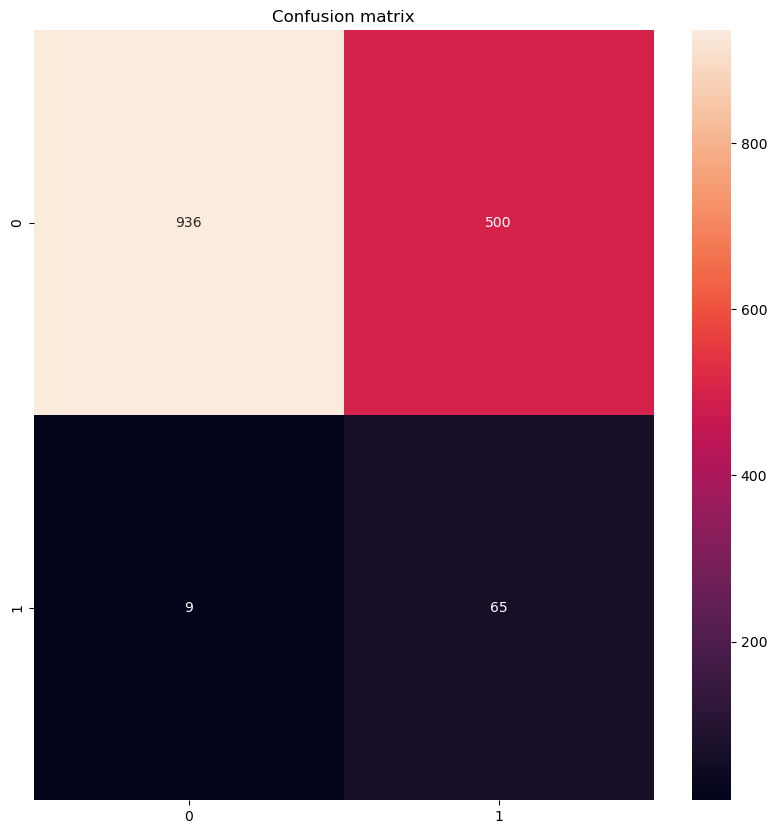

In [74]:
### Lineal Regression

# Train and optimize models with mlflow and hyperopt to get the best recall score
import mlflow
import mlflow.sklearn
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression

mlflow.set_experiment("Stroke_Lineal_Regression")

# Define the search space for random forest model
space = {'penalty': hp.choice('penalty', ['l2', 'none']),
                'tol': hp.uniform('tol', 0.00001, 0.0001),
                'C': hp.uniform('C', 0.1, 1.0),
                'max_iter': hp.choice('max_iter', range(100, 1000)),
                'solver': hp.choice('solver', ['lbfgs', 'newton-cg', 'newton-cholesky','sag', 'saga']),
        }

# Define the objective function
def objective(space):
    with mlflow.start_run():

        model = LogisticRegression(penalty=space['penalty'],
                                        tol=space['tol'],
                                        C=space['C'],
                                        max_iter=space['max_iter'],
                                        solver=space['solver'],
                                        # Use all available cores to speed up training
                                        n_jobs=-1)

        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test)
        recall = recall_score(y_test, y_pred)
        mlflow.log_param("penalty", space['penalty'])
        mlflow.log_param("tol", space['tol'])
        mlflow.log_param("C", space['C'])
        mlflow.log_param("max_iter", space['max_iter'])
        mlflow.log_param("solver", space['solver'])
        mlflow.log_metric("recall", recall)
        mlflow.sklearn.log_model(model, "model")
        return {'loss': -recall, 'status': STATUS_OK}

# Run the optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=500,
            trials=trials)

# Print the best parameters
print(best)

# Print the best recall score
print(-trials.best_trial['result']['loss'])

# Parameters of the best model
print(trials.best_trial['misc']['vals'])

hyper_params = {
        'penalty': ['l2', 'none'],
        'tol': [0.00001, 0.0001],
        'C': [0.1, 1.0],
        'max_iter': range(100, 1000),
        'solver': ['lbfgs', 'newton-cg', 'newton-cholesky','sag', 'saga'],
}

model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test)
recall = recall_score(y_test, y_pred)
print('Recall score: ', recall)
mlflow.sklearn.log_model(model, "model")
# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

import pickle
filename = './models/LR/finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')

# end run

mlflow.end_run()


# Conclusion

Both of the optimized classical Machine learning models obtained similar results, but the Random Forest model is more suitable for this problem, because it is able to generalize the data better than the Logistic Regression model.
Both of te models where optimized for recall, with 500 optimization iterations, and the best model was selected based on the recall score.
